In [ ]:
# compare test set cluster assignment probabilities for the special sample set, IXI, and mdd only

In [390]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import matlib
import csv
from sklearn.manifold import TSNE
import matplotlib
from beta_aggregate import vector_mse
from utils import contingency_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def colorscatter(x, y, d, ax, legendyn):
    try:
        groups = set(y[~np.isnan(y)])
    except:
        groups = np.unique(y)
    colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
    ctr = -1
    for g in groups:
        ctr += 1
        findme = np.where(y == g.astype(int))[0]
        cc = np.expand_dims(colors[g.astype(int)], axis=0)
        ax.scatter(x[findme, 0], x[findme, 1], c=cc, s=d[findme] * 5)
    if legendyn==1:
        plt.legend(groups)

In [241]:
# load in the control data to get data labels
Xctrlinit = pd.read_csv(r'/Users/lee_jollans/Projects/MARS_GSK_project/data/alldatacollect/controldata.csv',header=None);    
labels = np.vstack(Xctrlinit.values[0,:]).astype(str)
surf_v = np.linspace(0, 67, 68).astype(int)
thick_v = np.linspace(68, 67 + 68, 68).astype(int)
subc_v = np.append(np.linspace(137, 143, 7), np.linspace(145, 151, 7)).astype(int)
cov_v = [136, 144]
cov_s = [154, 155]
cov_t = [152, 153]
cov_c = [156, 157, 158, 159]

In [377]:
mdd_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/FEB_')
all_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_')
mdd_datadir = ('/Users/lee_jollans/Projects/clustering_pilot/residfiles_all_210220/MDD__')
ixi_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/IXI/IXI_')

sets = [
    "Tc",
    "Sc",
    "TSc",
    "Tc_tc",
    "Sc_sc",
    "TSc_tsc",
    "Tct_s",
    "Scs_s",
    "Tct_Scs_s",
    "Tct_tc_s",
    "Scs_sc_s",
    "Tct_Scs_tc_sc_s",
]

# load cv assignments
cv_assignment_dir = "/Users/lee_jollans/Documents/GitHub/ML_in_python/export_251019/"
with open((cv_assignment_dir + "CVassig398.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    mdd_cv_assignment = np.array(list(reader)).astype(float)
with open((cv_assignment_dir + "CVassig740.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    all_cv_assignment = np.array(list(reader)).astype(float)    
with open((cv_assignment_dir + "CVassigIXI.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    ixi_cv_assignment = np.array(list(reader)).astype(float)   
    
# load labels
with open((all_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    all_labelsmain2 = pickle.load(file)
with open((ixi_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    ixi_labelsmain2 = pickle.load(file)
with open((mdd_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    mdd_mdd_labelsmain2 = pickle.load(file)
with open((mdd_savedir + 'all_labelsmain_ctrl_sigmoid.pkl'), "rb") as file:
    mdd_ctrl_labelsmain2 = pickle.load(file)
    
# load probabilities
with open((all_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    all_probamain2 = pickle.load(file)
with open((ixi_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    ixi_probamain2 = pickle.load(file)
with open((mdd_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    mdd_mdd_probamain2 = pickle.load(file)
with open((mdd_savedir + 'all_probamain_ctrl_sigmoid.pkl'), "rb") as file:
    mdd_ctrl_probamain2 = pickle.load(file)
    
# load diagnosis labels
with open('/Users/lee_jollans/Projects/clustering_pilot/ALL/ALL_samples_idx.csv', newline='') as csvfile:
    sampleidx = list(csv.reader(csvfile))
tmpsampleidx = np.array([int(sampleidx[i][0]) for i in range(len(sampleidx))])
sampleidx = np.full([740],np.nan)
sampleidx[np.where(tmpsampleidx==1)[0]]=4
sampleidx[np.where(tmpsampleidx==2)[0]]=7
sampleidx[np.where(tmpsampleidx==3)[0]]=5
sampleidx[np.where(tmpsampleidx==4)[0]]=6
sampleidx[np.where(tmpsampleidx==5)[0]]=1
sampleidx[np.where(tmpsampleidx==6)[0]]=2
sampleidx[np.where(tmpsampleidx==7)[0]]=3

mddinall = np.where(sampleidx==2)
dummy_mdd = np.zeros(740);
dummy_mdd[mddinall]=np.ones(398)

In [167]:
# extract testprobabilities for mainfold test sets
all_testproba = np.full([8,12,4],np.nan)
ixi_testproba = np.full([8,12,4],np.nan)
mdd_testproba_mddresid = np.full([8,12,4],np.nan)
mdd_testproba_ctrlresid = np.full([8,12,4],np.nan)

for s in range(len(sets)):
    for mf in range(4):
        maintest_all = np.where(np.isnan(all_cv_assignment[:,mf]))[0]
        maintest_ixi = np.where(np.isnan(ixi_cv_assignment[:,mf]))[0]
        maintest_mdd = np.where(np.isnan(mdd_cv_assignment[:,mf]))[0]
        
        for k in range(8):            
            all_test = all_probamain2[maintest_all,s,k,mf]
            ixi_test = ixi_probamain2[maintest_ixi,s,k,mf]
            mdd_mdd_test = mdd_mdd_probamain2[maintest_mdd,s,k,mf]
            mdd_ctrl_test = mdd_ctrl_probamain2[maintest_mdd,s,k,mf]
            
            all_testproba[k,s,mf]=np.nanmean(all_test)
            ixi_testproba[k,s,mf]=np.nanmean(ixi_test)
            mdd_testproba_mddresid[k,s,mf]=np.nanmean(mdd_mdd_test)
            mdd_testproba_ctrlresid[k,s,mf]=np.nanmean(mdd_ctrl_test)

In [168]:
modality = [0,1,2]*4
datatype = [0,0,0,1,1,1,2,2,2,3,3,3]

df = pd.DataFrame({}, columns=['set','mod','res_cov','data','CV', 'k','testproba'])

for s in range(len(sets)):
    for k in range(8):
        for mf in range(4):
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'all','CV':mf,'k':k+2,'testproba': [all_testproba[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'ixi','CV':mf,'k':k+2,'testproba': [ixi_testproba[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'mdd_mddresid','CV':mf,'k':k+2,'testproba': [mdd_testproba_mddresid[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'mdd_ctrlresid','CV':mf,'k':k+2,'testproba': [mdd_testproba_ctrlresid[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
               

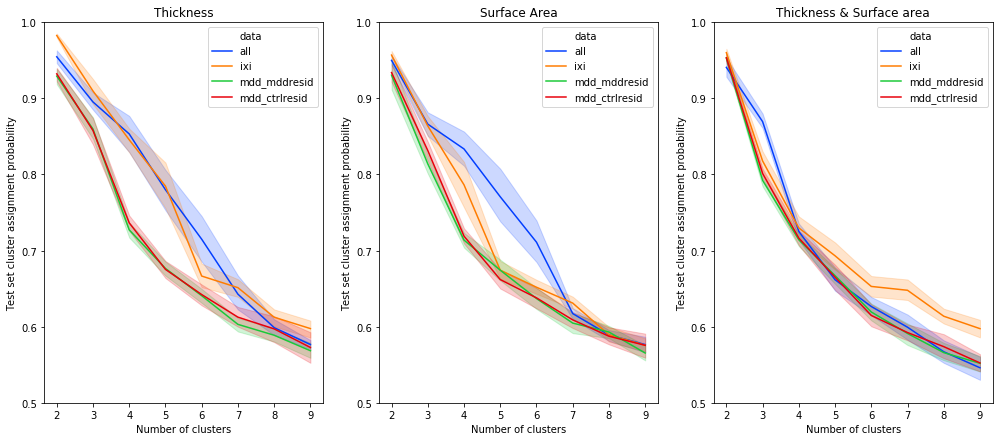

In [487]:
fig = plt.figure(figsize=[17,7])
modlabel=['Thickness','Surface Area','Thickness & Surface area']
for mod in range(3):
    plt.subplot(1,3,mod+1)
    df2=df[df['mod']==mod]
    sns.lineplot(y='testproba',x='k',hue='data',data=df2, palette='bright')
    plt.ylim([0.5,1])
    plt.xlabel('Number of clusters')
    plt.ylabel('Test set cluster assignment probability')
    plt.title(modlabel[mod])
plt.show()

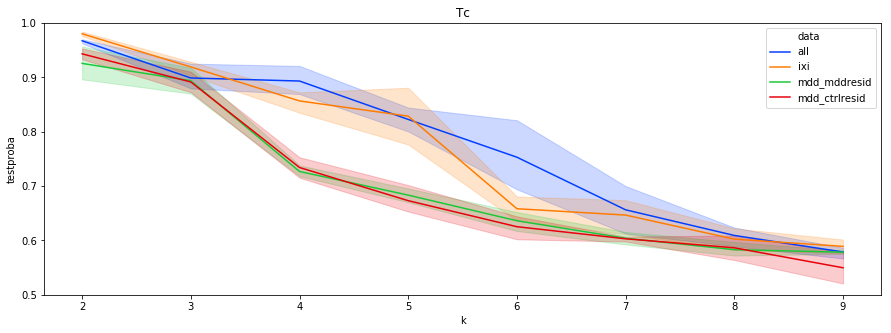

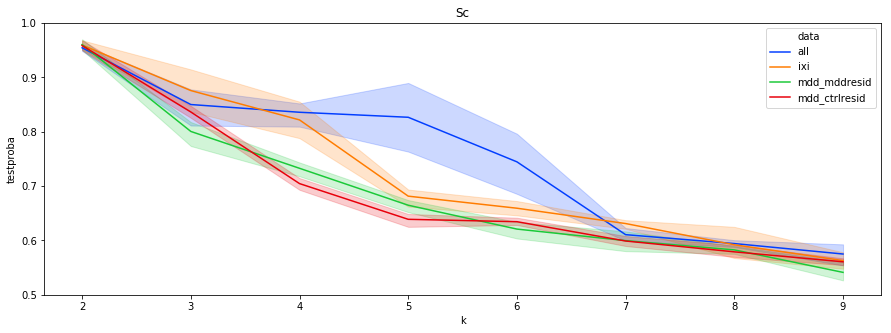

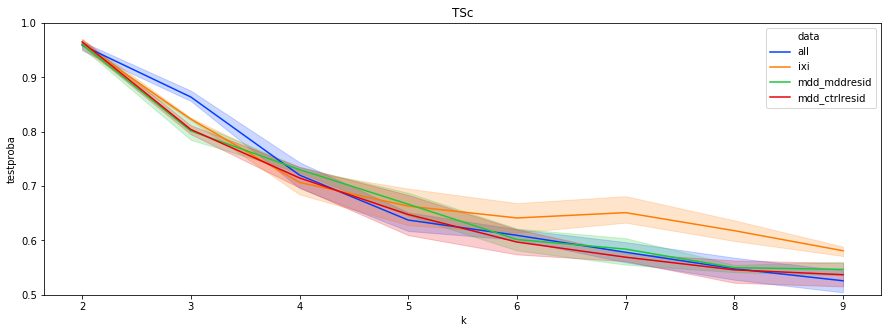

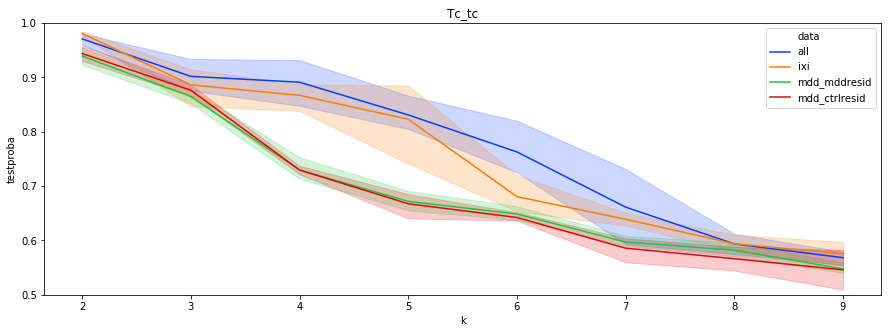

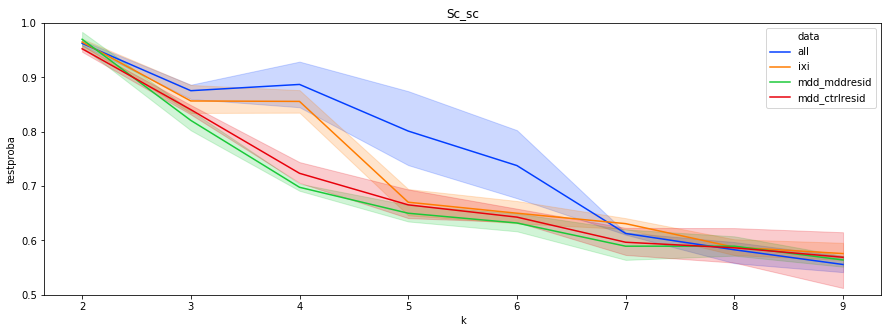

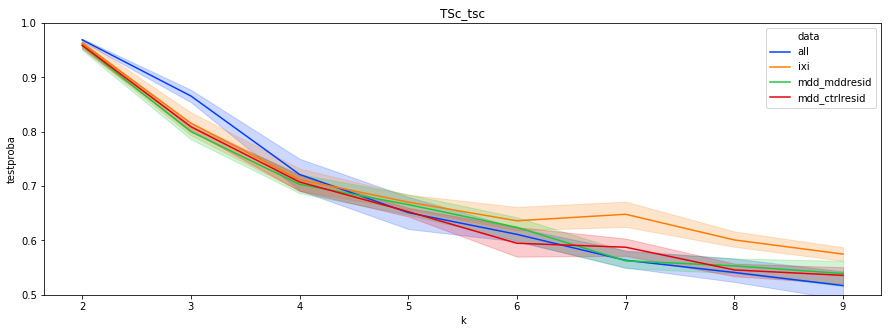

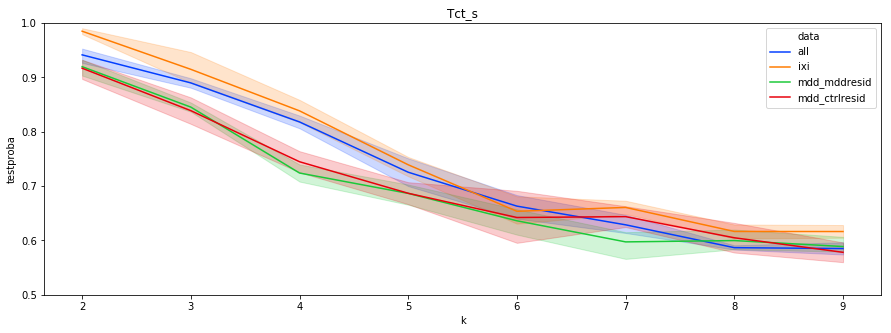

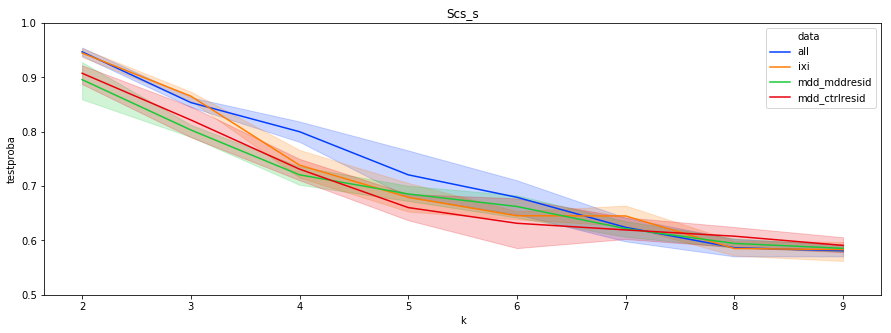

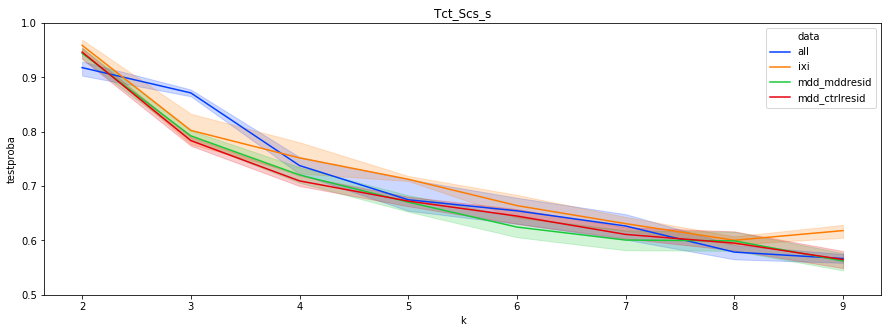

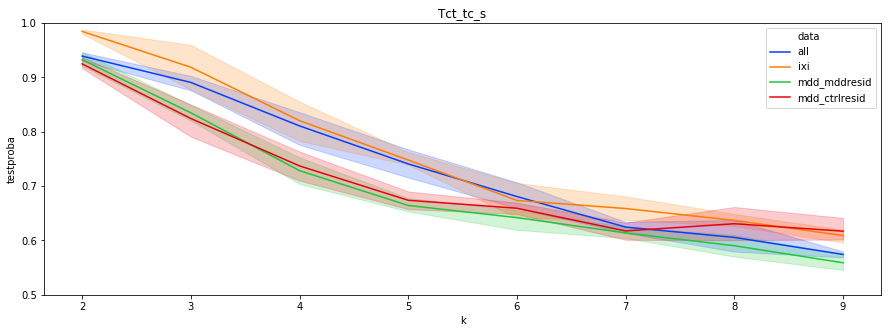

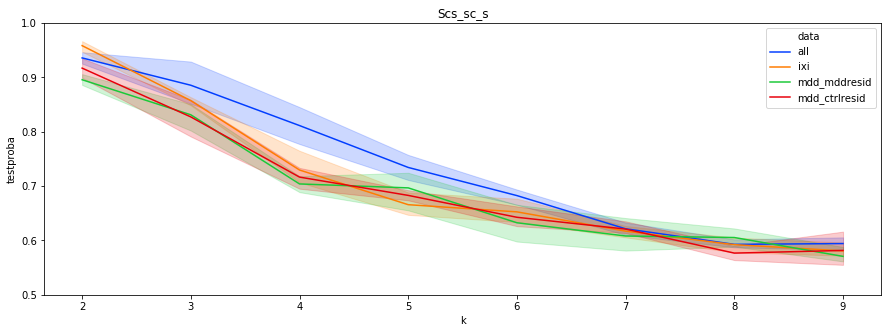

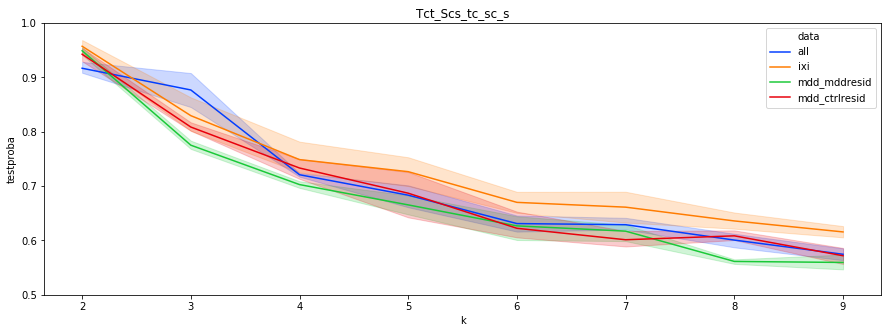

In [169]:
for s in range(len(sets)):
    fig = plt.figure(figsize=[15,5])
    df2=df[df['set']==sets[s]]
    sns.lineplot(y='testproba',x='k',hue='data',data=df2, palette='bright')
    plt.ylim([0.5,1])
    plt.title(sets[s])
plt.show()

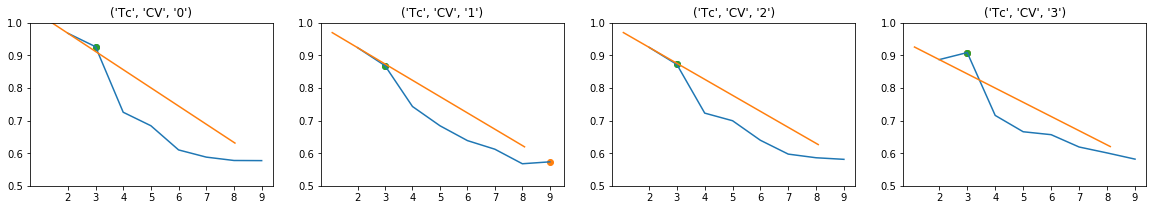

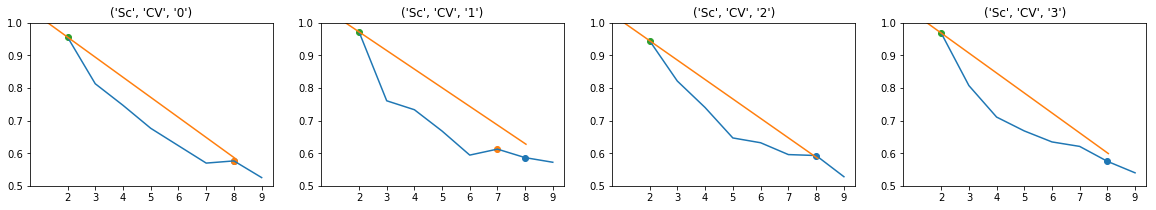

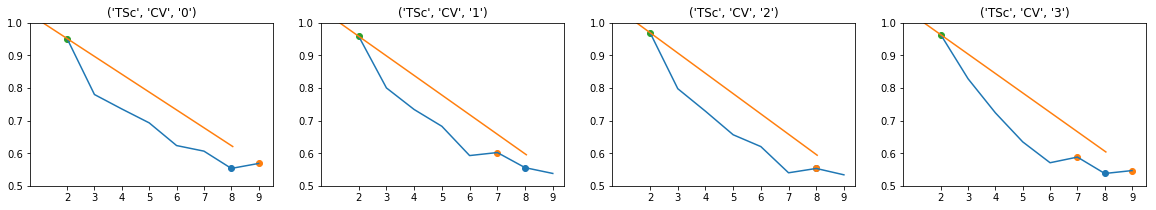

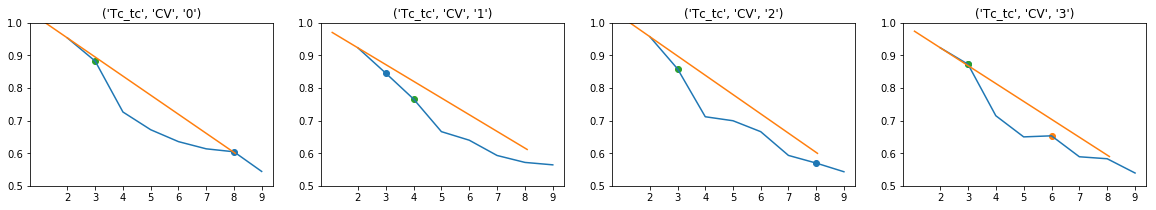

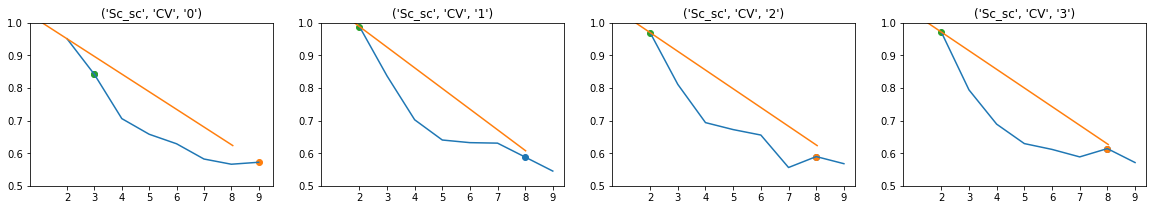

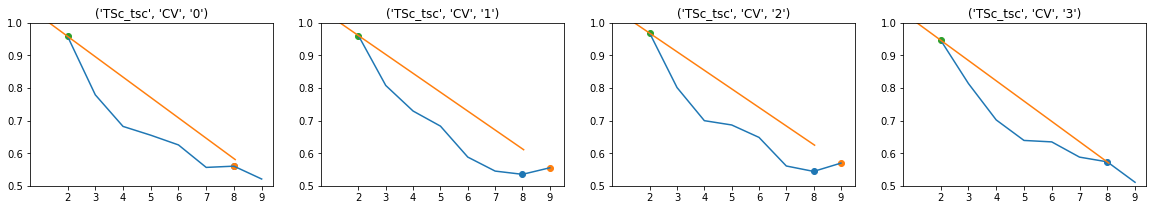

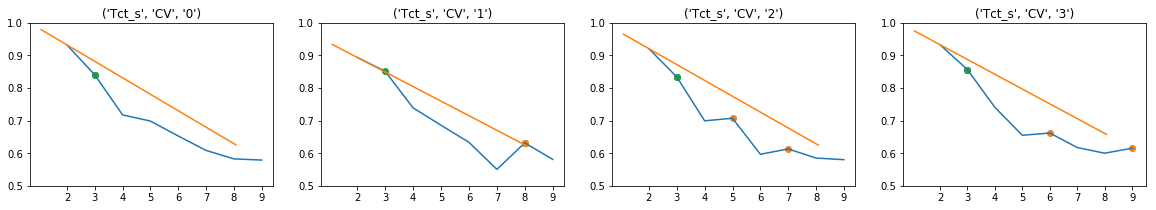

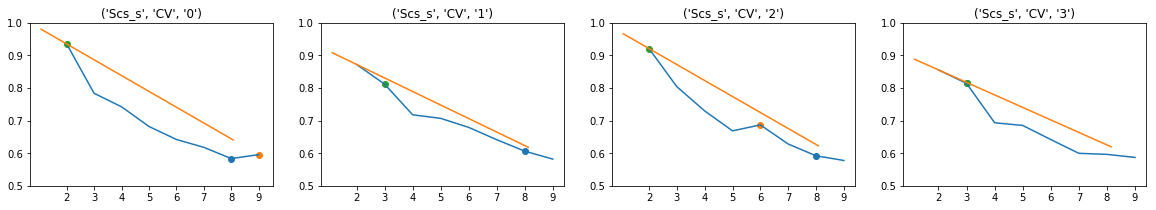

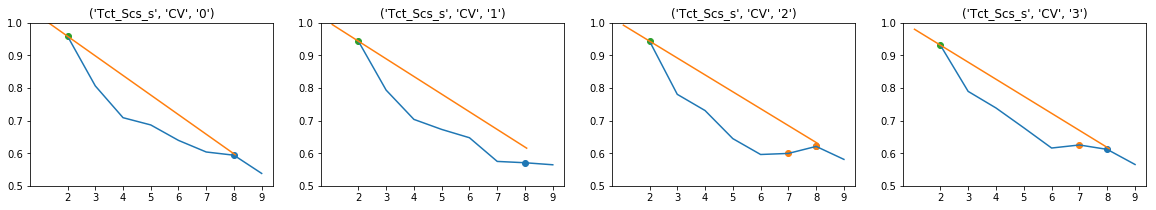

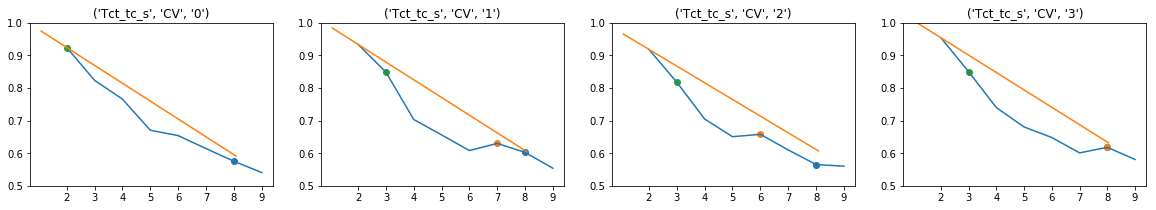

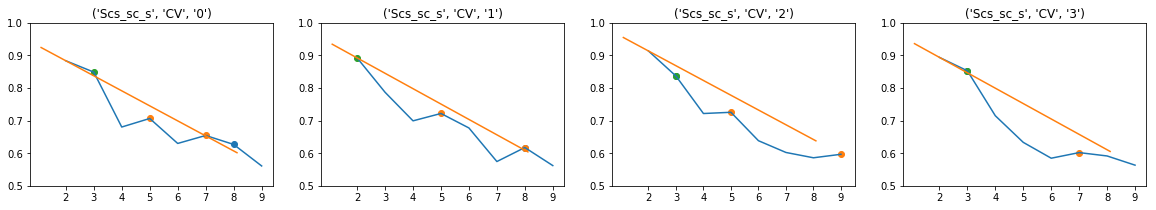

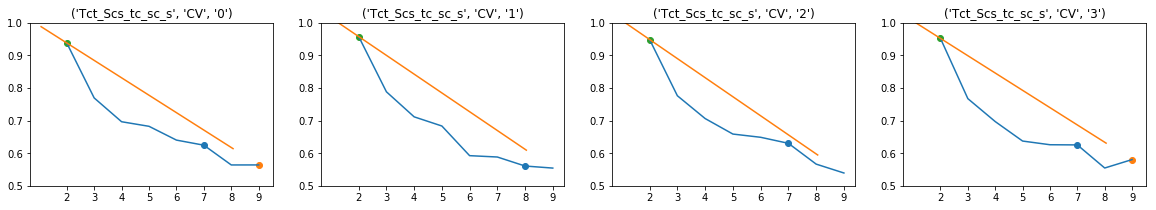

In [147]:
# now go through every mainfold and select optimal point in the testproba curve
k_to_use_mdd_mddresid_mindist = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_increase = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_decrease = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_incodec = np.full([len(sets),4],np.nan)
for s in range(len(sets)):
    fig = plt.figure(figsize=[20,3])
    for mf in range(4):
        plt.subplot(1,4,mf+1)
        curve = mdd_testproba_mddresid[:,s,mf]
        plt.plot(curve)
        
        # get line from first to last point to get elbow/knee
        allCoord = np.vstack((np.arange(len(curve)), curve)).T
        lineVec = allCoord[-1] - allCoord[0]
        lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
        vecFromFirst = allCoord - curve[0]
        scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, len(curve), 1), axis=1)
        vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
        vecToLine = vecFromFirst - vecFromFirstParallel
        plt.plot(vecFromFirstParallel[:,0],vecFromFirstParallel[:,1]+curve[0])
        
        # distance from parallel
        distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
        a = distToLine[1:-1]
        i = np.where(a==np.min(a))[0]+1
        k_to_use_mdd_mddresid_mindist[s,mf]=i
        plt.scatter(i,curve[i])
        
        increases_before = (curve[1:]-curve[:-1])
        k_to_use_mdd_mddresid_increase[s,mf]=np.where(increases_before==np.max(increases_before))[0]+1
        increases = np.where(increases_before>0)[0]+1
        plt.scatter(increases,curve[increases])
        
        decreases_after = (curve[:-1]-curve[1:])
        k_to_use_mdd_mddresid_decrease[s,mf]=np.where(decreases_after==np.max(decreases_after))[0]
        max_decrease_after = np.where(decreases_after == np.max(decreases_after))[0]
        plt.scatter(max_decrease_after,curve[max_decrease_after])

        decrease_over_increase = decreases_after[1:]/abs(increases_before[:-1])
        k_to_use_mdd_mddresid_incodec[s,mf]=np.where(decrease_over_increase==np.max(decrease_over_increase))[0]+3
        
        plt.ylim([0.5,1])
        plt.title((sets[s], 'CV',str(mf)))
        plt.xticks(np.arange(8),np.arange(8)+2)
    plt.show()

In [148]:
for s in range(len(sets)):
    print(k_to_use_mdd_mddresid_mindist[s,:]+2,k_to_use_mdd_mddresid_increase[s,:]+2,k_to_use_mdd_mddresid_decrease[s,:]+2,k_to_use_mdd_mddresid_incodec[s,:],sets[s])

[3. 3. 3. 3.] [9. 9. 9. 3.] [3. 3. 3. 3.] [3. 3. 3. 3.] Tc
[8. 8. 8. 8.] [8. 7. 8. 7.] [2. 2. 2. 2.] [8. 4. 8. 7.] Sc
[8. 8. 8. 8.] [9. 7. 8. 7.] [2. 2. 2. 2.] [7. 7. 6. 7.] TSc
[8. 3. 8. 3.] [8. 9. 5. 6.] [3. 4. 3. 3.] [8. 6. 5. 6.] Tc_tc
[3. 8. 8. 8.] [9. 7. 8. 8.] [3. 2. 2. 2.] [6. 7. 6. 8.] Sc_sc
[8. 8. 8. 8.] [8. 9. 9. 6.] [2. 2. 2. 2.] [8. 5. 5. 6.] TSc_tsc
[3. 8. 3. 3.] [9. 8. 7. 9.] [3. 3. 3. 3.] [5. 3. 5. 6.] Tct_s
[8. 8. 8. 3.] [9. 5. 6. 8.] [2. 3. 2. 3.] [4. 5. 6. 5.] Scs_s
[8. 8. 8. 8.] [8. 8. 8. 7.] [2. 2. 2. 2.] [8. 6. 8. 8.] Tct_Scs_s
[8. 8. 8. 8.] [6. 7. 6. 8.] [2. 3. 3. 3.] [6. 8. 6. 8.] Tct_tc_s
[8. 8. 3. 3.] [5. 8. 9. 7.] [3. 2. 3. 3.] [3. 6. 5. 3.] Scs_sc_s
[7. 8. 7. 7.] [9. 7. 6. 9.] [2. 2. 2. 2.] [7. 7. 7. 7.] Tct_Scs_tc_sc_s


In [ ]:
k_to_use_mdd_mddresid = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid[0,:]=[3,3,3,3] #t
k_to_use_mdd_mddresid[1,:]=[8,8,8,7] #s
k_to_use_mdd_mddresid[2,:]=[7,7,8,7] #ts
k_to_use_mdd_mddresid[3,:]=[3,3,3,3] #t
k_to_use_mdd_mddresid[4,:]=[3,8,6,8] #s
k_to_use_mdd_mddresid[5,:]=[6,5,6,7] #ts
k_to_use_mdd_mddresid[6,:]=[3,3,3,3] #t
k_to_use_mdd_mddresid[7,:]=[2,3,2,6] #s
k_to_use_mdd_mddresid[8,:]=[8,9,8,8] #ts
k_to_use_mdd_mddresid[9,:]=[4,3,3,3] #t
k_to_use_mdd_mddresid[10,:]=[8,7,8,8] #s
k_to_use_mdd_mddresid[11,:]=[7,8,7,6] #ts

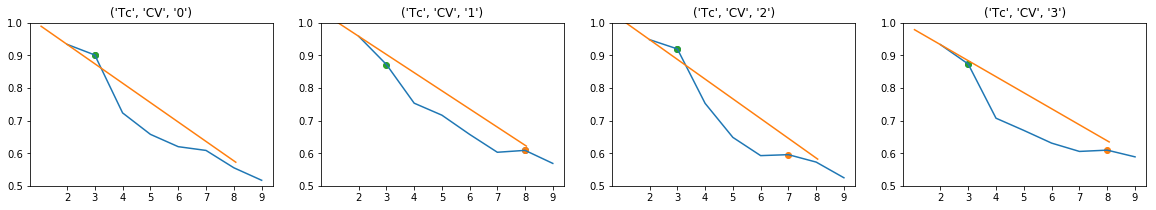

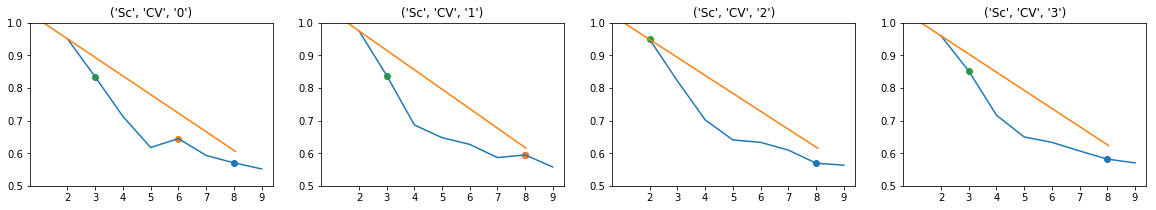

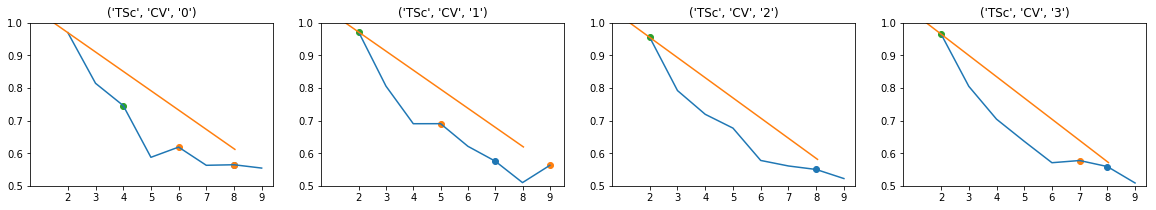

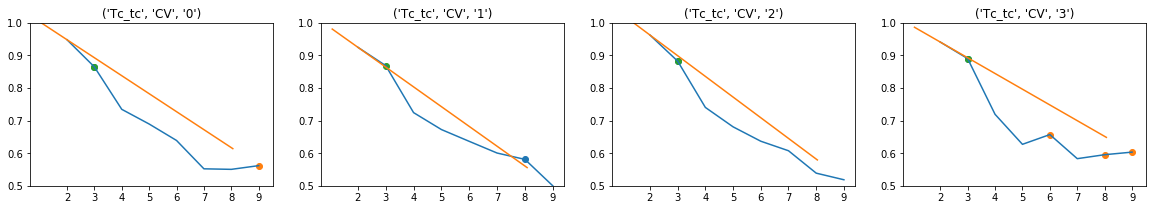

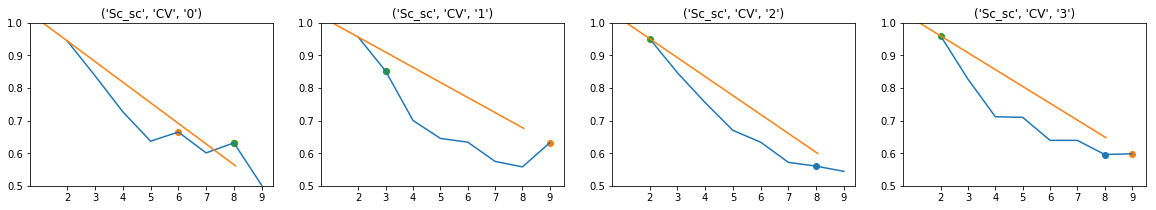

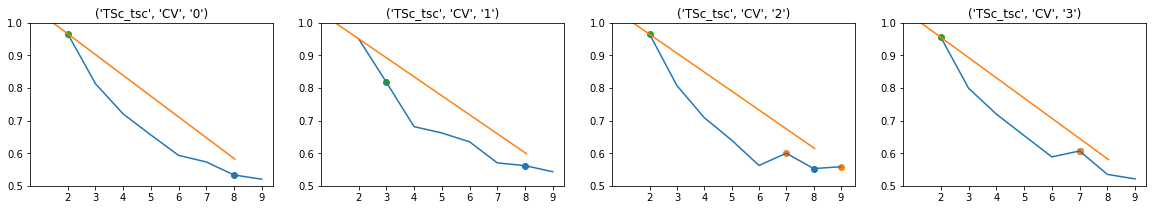

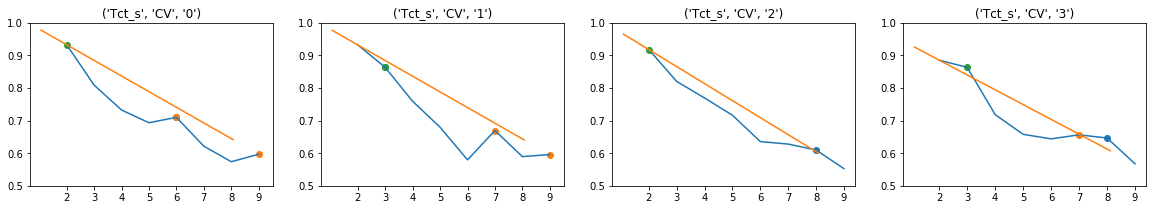

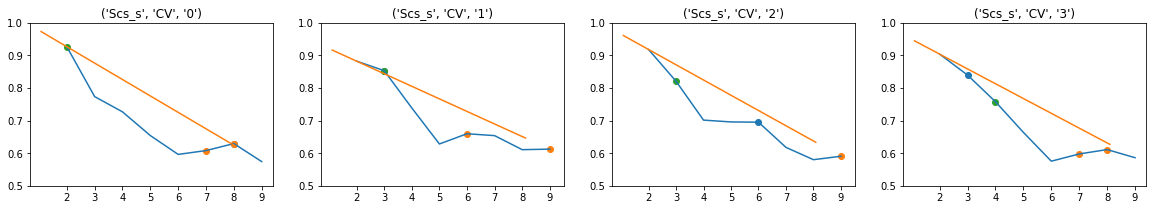

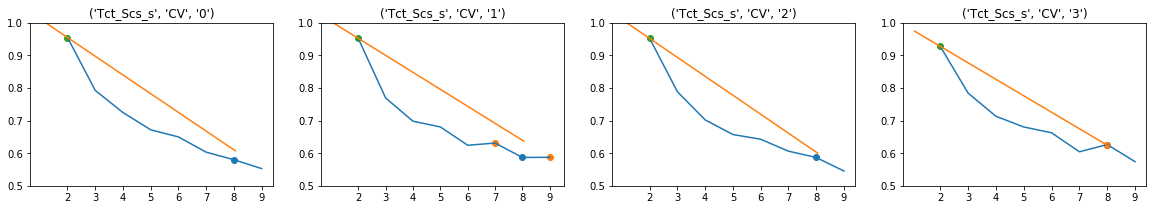

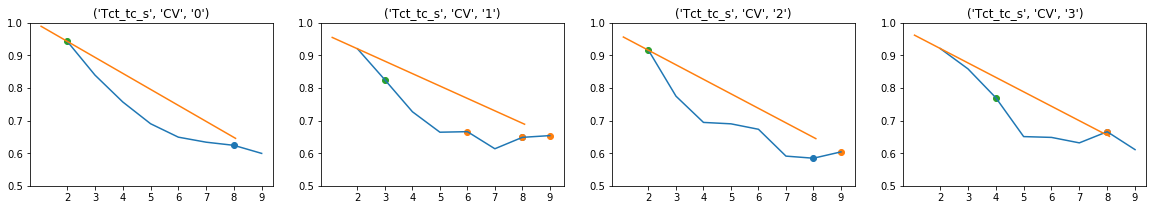

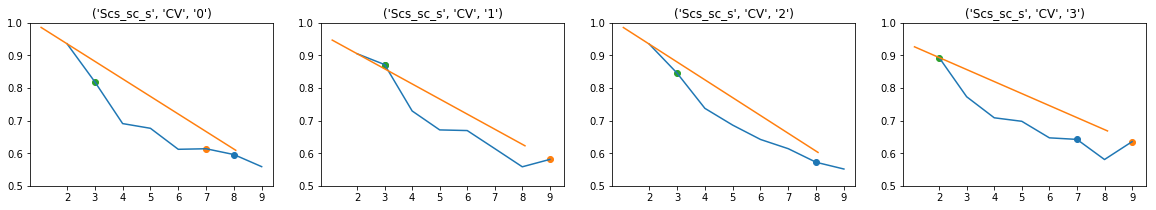

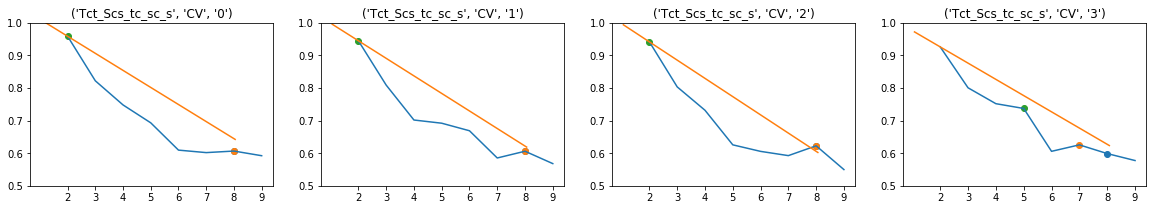

In [149]:
# same thing but plotting control corrected data
for s in range(len(sets)):
    fig = plt.figure(figsize=[20,3])
    for mf in range(4):
        plt.subplot(1,4,mf+1)
        curve = mdd_testproba_ctrlresid[:,s,mf]
        plt.plot(curve)
        
        # get line from first to last point to get elbow/knee
        allCoord = np.vstack((np.arange(len(curve)), curve)).T
        lineVec = allCoord[-1] - allCoord[0]
        lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
        vecFromFirst = allCoord - curve[0]
        scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, len(curve), 1), axis=1)
        vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
        vecToLine = vecFromFirst - vecFromFirstParallel
        plt.plot(vecFromFirstParallel[:,0],vecFromFirstParallel[:,1]+curve[0])
        
        # distance from parallel
        distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
        a = distToLine[1:-1]
        i = np.where(a==np.min(a))[0]+1
        plt.scatter(i,curve[i])
        
        increases_before = (curve[1:]-curve[:-1])
        increases = np.where(increases_before>0)[0]+1
        plt.scatter(increases,curve[increases])
        
        decreases_after = (curve[:-1]-curve[1:])
        max_decrease_after = np.where(decreases_after == np.max(decreases_after))[0]
        plt.scatter(max_decrease_after,curve[max_decrease_after])

        decrease_over_increase = decreases_after[1:]/abs(increases_before[:-1])
        
        plt.ylim([0.5,1])
        plt.title((sets[s], 'CV',str(mf)))
        plt.xticks(np.arange(8),np.arange(8)+2)
    plt.show()

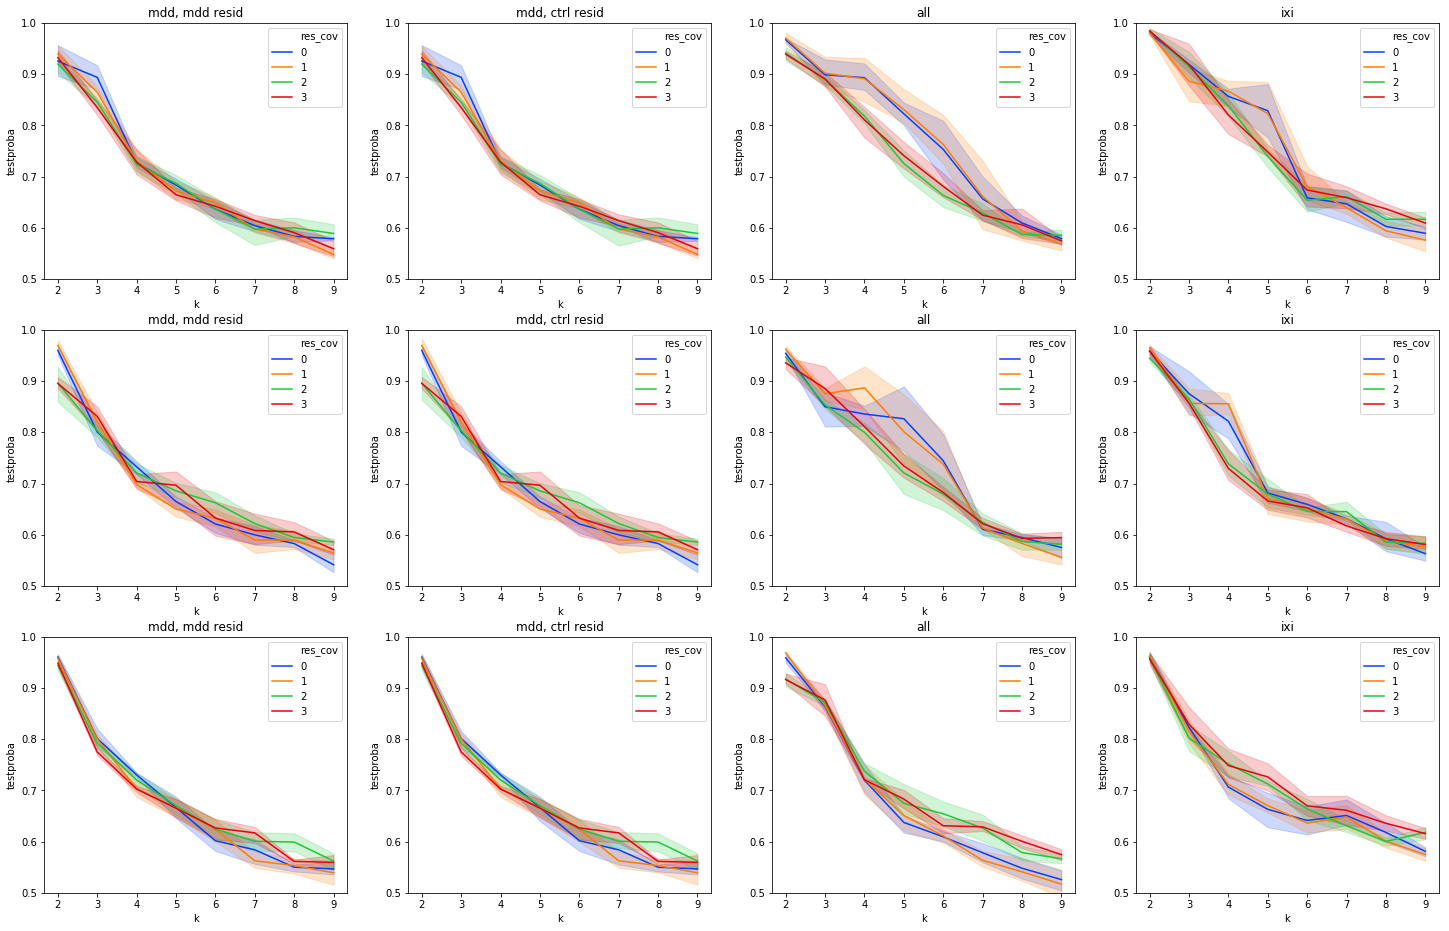

In [171]:
# plot all thickness lines
fig=plt.figure(figsize=[25,16])
a=[0,3,6,9]
ctr=0
for mod in range(3):
    plt.subplot(3,4,(mod*4)+1); plt.title('mdd, mdd resid'); plt.ylim([0.5,1])
    df2=df[(df['mod']==mod) & (df['data']=='mdd_mddresid')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')

    plt.subplot(3,4,(mod*4)+2); plt.title('mdd, ctrl resid'); plt.ylim([0.5,1])
    pdf2=df[(df['mod']==mod) & (df['data']=='mdd_ctrlresid')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')

    plt.subplot(3,4,(mod*4)+3); plt.title('all'); plt.ylim([0.5,1])
    df2=df[(df['mod']==mod) & (df['data']=='all')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')
    
    plt.subplot(3,4,(mod*4)+4); plt.title('ixi'); plt.ylim([0.5,1])
    df2=df[(df['mod']==mod) & (df['data']=='ixi')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')
        
plt.show()

In [172]:
# let's look at the solutions for thickness
print('three cluster solutions for thickness')
print('mdd resid mdd:',np.mean(mdd_testproba_mddresid[1,[0,3,6,9],:],axis=1))
print('mdd resid ctrl:',np.mean(mdd_testproba_ctrlresid[1,[0,3,6,9],:],axis=1))
print('four cluster solutions for thickness')
print('all resid ctrl:',np.mean(all_testproba[2,[0,3,6,9],:],axis=1))
print('five cluster solutions for thickness')
print('ixi resid ctrl:',np.mean(ixi_testproba[3,[0,3,6,9],:],axis=1))

three cluster solutions for thickness
mdd resid mdd: [0.89382203 0.86475453 0.84527262 0.83485817]
mdd resid ctrl: [0.89150376 0.87632924 0.83874823 0.82433484]
four cluster solutions for thickness
all resid ctrl: [0.89323743 0.89110072 0.81801009 0.81073397]
five cluster solutions for thickness
ixi resid ctrl: [0.82868098 0.82300219 0.73916489 0.74795562]


In [249]:
# load aggregated beta weigths per CV fold
mdd_mdd_betas = np.full([83,3,4],np.nan)
mdd_ctrl_betas = np.full([83,3,4],np.nan)
all_betas = np.full([83,4,4],np.nan)
ixi_betas = np.full([83,5,4],np.nan)

for mf in range(4):
    with open((mdd_savedir + 'Tc_aggregated_betas_k1_' + str(mf) + '.csv'), "r") as f:
        mdd_mdd_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((mdd_savedir + 'Tc_aggregated_betas_k1_ctrl_' + str(mf) + '.csv'), "r") as f:
        mdd_ctrl_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((all_savedir + 'Tc_aggregated_betas_k2_' + str(mf) + '.csv'), "r") as f:
        all_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((ixi_savedir + 'Tc_aggregated_betas_k3_' + str(mf) + '.csv'), "r") as f:
        ixi_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)

# load data
with open((mdd_datadir + 'Tc.csv'), "r") as f:
    mdd_mdd_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((mdd_datadir + 'Tc_ctrl.csv'), "r") as f:
    mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((all_savedir + 'Tc_ctrl.csv'), "r") as f:
    all_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((ixi_savedir + 'Tc.csv'), "r") as f:
    ixi_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)

Tclabels = labels[np.concatenate([thick_v, subc_v])]

In [175]:
# squish data into two dimensions
mdd_mdd_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(mdd_mdd_Tc)
mdd_ctrl_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(mdd_ctrl_Tc)
all_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(all_Tc)
ixi_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(ixi_Tc)

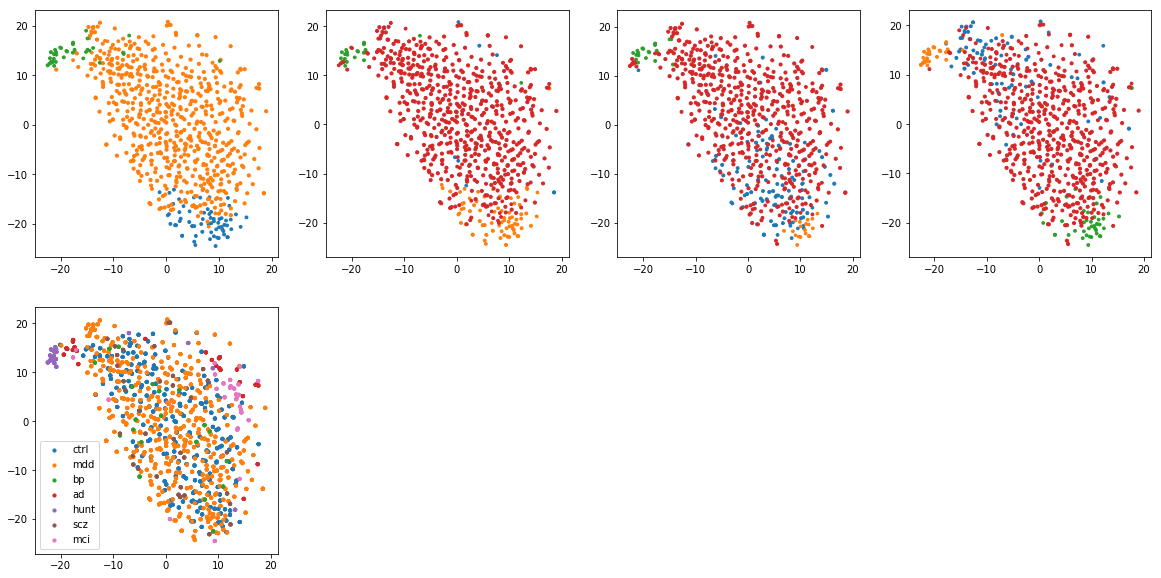

In [177]:
fig = plt.figure(figsize=[20,10])
for mf in range(4):

    labels = all_labelsmain2[:,0,2,mf]
    probas = all_probamain2[:,0,2,mf]+1
    
    ax = plt.subplot(2,4,mf+1)
    colorscatter(all_tsne,labels,probas, ax)
    
    ax = plt.subplot(2,4,5)
    colorscatter(all_tsne,sampleidx,np.ones(740)*2, ax)
    plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
    
plt.show()

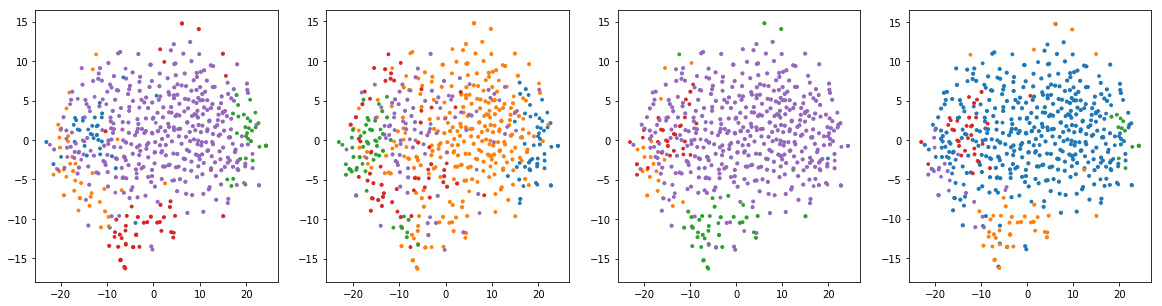

In [178]:
fig = plt.figure(figsize=[20,5])
for mf in range(4):

    labels = ixi_labelsmain2[:,0,3,mf]
    probas = ixi_probamain2[:,0,3,mf]+1
    
    ax = plt.subplot(1,4,mf+1)
    colorscatter(ixi_tsne,labels,probas, ax)
    
plt.show()

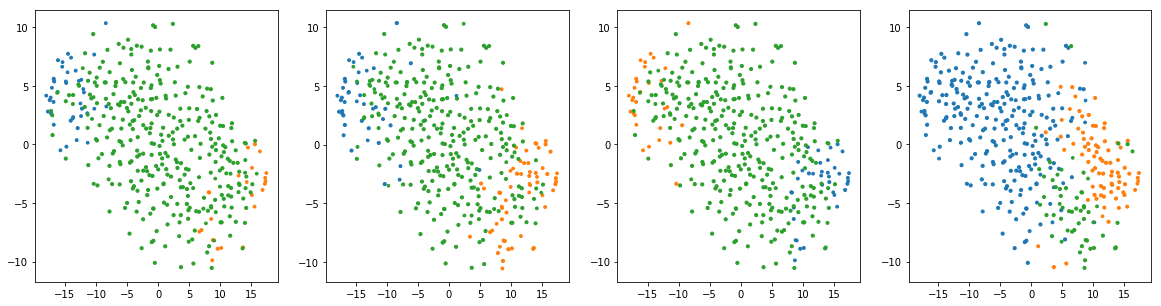

In [179]:
fig = plt.figure(figsize=[20,5])
for mf in range(4):

    labels = mdd_ctrl_labelsmain2[:,0,1,mf]
    probas = mdd_ctrl_probamain2[:,0,1,mf]+1
    
    ax = plt.subplot(1,4,mf+1)
    colorscatter(mdd_ctrl_tsne,labels,probas, ax)
    
plt.show()

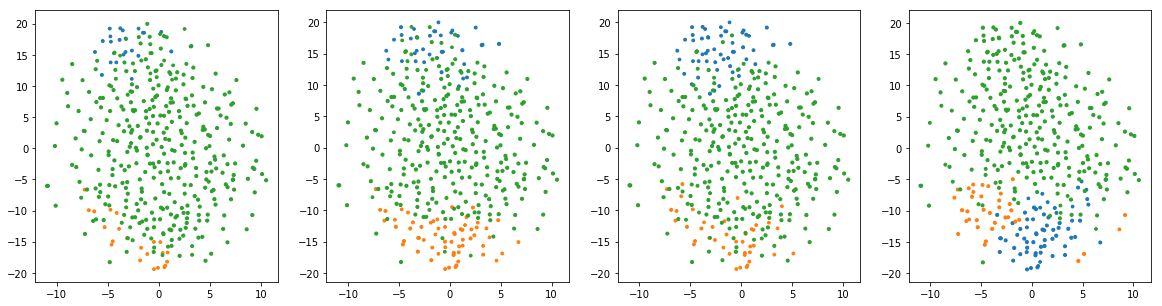

In [180]:
fig = plt.figure(figsize=[20,5])
for mf in range(4):

    labels = mdd_mdd_labelsmain2[:,0,1,mf]
    probas = mdd_mdd_probamain2[:,0,1,mf]+1
    
    ax = plt.subplot(1,4,mf+1)
    colorscatter(mdd_mdd_tsne,labels,probas, ax)
    
plt.show()

In [502]:
def spit_out_vector_overlap(mddcrit,allcrit):
    print(np.corrcoef(mddcrit,allcrit)[0,1])
    plt.plot(mddcrit); 
    plt.plot(allcrit); 
    aaa=np.nanmean([mddcrit,allcrit],axis=0)
    plt.plot(aaa); 
    plt.show()
    a=np.argsort(abs(aaa))
    plt.plot(aaa[a])
    print(Tclabels[a[-10:]])
    print([a[-10:]])
    print(aaa[a[-10:]])

0.2921023130080411


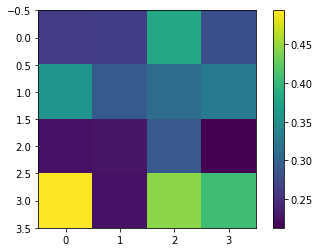

In [263]:
# how similar are the IXI clusters to the ALL clusters?
max_all_ixi_corrs=np.full([4,4],np.nan)
all_ixi_corr = np.full([4,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_all in range(4):
            for clus_ixi in range(5):
                crit_all = all_betas[1:,clus_all,mf1]
                crit_ixi = ixi_betas[1:,clus_ixi,mf2]
                all_ixi_corr[clus_all,clus_ixi,mf1,mf2] = np.corrcoef(crit_all, crit_ixi)[0,1]
        max_all_ixi_corrs[mf1,mf2]=(np.nanmax(abs(all_ixi_corr[:,:,mf1,mf2])))
print(np.median(max_all_ixi_corrs))
fig=plt.figure(); plt.imshow(max_all_ixi_corrs); plt.colorbar(); plt.show()

0.3029166821479835


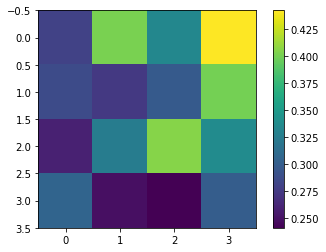

In [264]:
# how similar are the IXI clusters to the MDD clusters?
max_mdd_ixi_corrs=np.full([4,4],np.nan)
mdd_ixi_corr = np.full([3,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_mdd in range(3):
            for clus_ixi in range(5):
                crit_mdd = mdd_ctrl_betas[1:,clus_mdd,mf1]
                crit_ixi = ixi_betas[1:,clus_ixi,mf2]
                mdd_ixi_corr[clus_mdd,clus_ixi,mf1,mf2] = np.corrcoef(crit_mdd, crit_ixi)[0,1]
        max_mdd_ixi_corrs[mf1,mf2]=(np.max(abs(mdd_ixi_corr[:,:,mf1,mf2])))
print(np.median(max_mdd_ixi_corrs))
fig=plt.figure(); plt.imshow(max_mdd_ixi_corrs); plt.colorbar(); plt.show()

0.37324583944189815


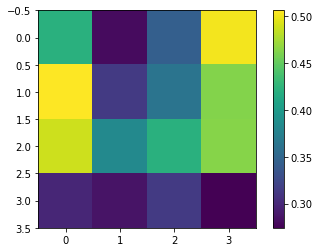

In [265]:
# how similar are the ALL clusters to the MDD clusters?
max_mdd_all_corrs=np.full([4,4],np.nan)
mdd_all_corr = np.full([3,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_mdd in range(3):
            for clus_all in range(4):
                crit_mdd = mdd_ctrl_betas[1:,clus_mdd,mf1]
                crit_all = all_betas[1:,clus_all,mf2]
                mdd_all_corr[clus_mdd,clus_all,mf1,mf2] = np.corrcoef(crit_mdd, crit_all)[0,1]
        max_mdd_all_corrs[mf1,mf2]=(np.nanmax(abs(mdd_all_corr[:,:,mf1,mf2])))
print(np.median(max_mdd_all_corrs))
fig=plt.figure(); plt.imshow(max_mdd_all_corrs); plt.colorbar(); plt.show()

[[ 0.52768971  0.18855649 -0.01399523]
 [ 0.14955057  0.59089189 -0.07146992]
 [-0.17484978 -0.08435152  0.79437707]]


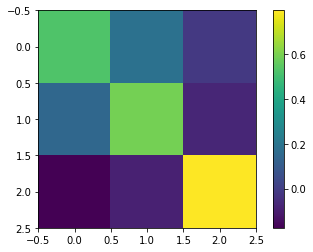

In [218]:
# how similar are the MDD clusters to the MDD clusters?
mdd_mdd_corr = np.full([3,3],np.nan)
for clus_mdd1 in range(3):
    for clus_mdd2 in range(3):
        crit_mdd1 = mdd_mdd_betas[1:,clus_mdd1,0]
        crit_mdd2 = mdd_ctrl_betas[1:,clus_mdd2,0]
        mdd_mdd_corr[clus_mdd1,clus_mdd2] = np.corrcoef(crit_mdd1, crit_mdd2)[0,1]
print(mdd_mdd_corr)   
fig=plt.figure(); plt.imshow(mdd_mdd_corr); plt.colorbar(); plt.show()

In [276]:
# the two solutions that both contained the same MDD patients had th most overlap
# for every solution (every combination of mainfolds) pull the top match
clusmdd=np.full([82,16],np.nan)
clusall=np.full([82,16],np.nan)
ctr=-1
for mf1 in range(4): #mdd
    for mf2 in range(4): #all
        ctr+=1
        crit = mdd_all_corr[:,:,mf1,mf2]
        tophit=np.where(crit==np.nanmax(crit))
        print(tophit, np.nanmax(crit))
        clusmdd[:,ctr]=np.squeeze(mdd_mdd_betas[1:,tophit[0],mf1])
        clusall[:,ctr]=np.squeeze(all_betas[1:,tophit[1],mf2])

(array([1]), array([0])) 0.4214090611244982
(array([1]), array([1])) 0.24327732878822017
(array([2]), array([0])) 0.34394235835224585
(array([1]), array([2])) 0.5014932708886993
(array([1]), array([0])) 0.5058710776857457
(array([2]), array([0])) 0.2727187906271
(array([1]), array([1])) 0.3636617123887352
(array([2]), array([3])) 0.46320976306547085
(array([0]), array([0])) 0.48786238166313856
(array([0]), array([1])) 0.38282996649506107
(array([0]), array([1])) 0.4213208213512088
(array([0]), array([2])) 0.46381497693827717
(array([0]), array([2])) 0.24278101890078382
(array([1]), array([1])) 0.28685017663656087
(array([0]), array([3])) 0.31336915839336504
(array([1]), array([1])) 0.2538323379732205


0.3205171513245278


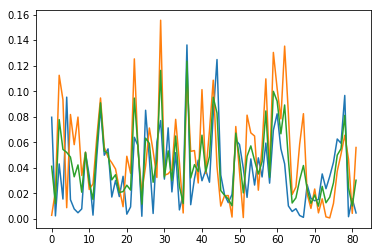

[['R_lateralorbitofrontal_thickavg']
 ['R_precuneus_thickavg']
 ['R_superiortemporal_thickavg']
 ['L_middletemporal_thickavg']
 ['R_superiorfrontal_thickavg']
 ['L_precentral_thickavg']
 ['R_lateraloccipital_thickavg']
 ['R_rostralmiddlefrontal_thickavg']
 ['L_supramarginal_thickavg']
 ['R_caudalmiddlefrontal_thickavg']]
[array([44, 57, 62, 13, 60, 22, 43, 59, 29, 36])]
[0.08291557 0.08452551 0.08920558 0.09090382 0.09225342 0.09461166
 0.0952625  0.09989587 0.11628507 0.12355715]


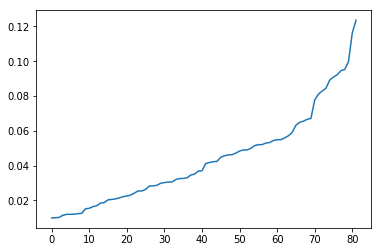

In [503]:
amdd=abs(np.median((clusmdd),axis=1))
aall=abs(np.median((clusall),axis=1))

spit_out_vector_overlap(amdd,aall)

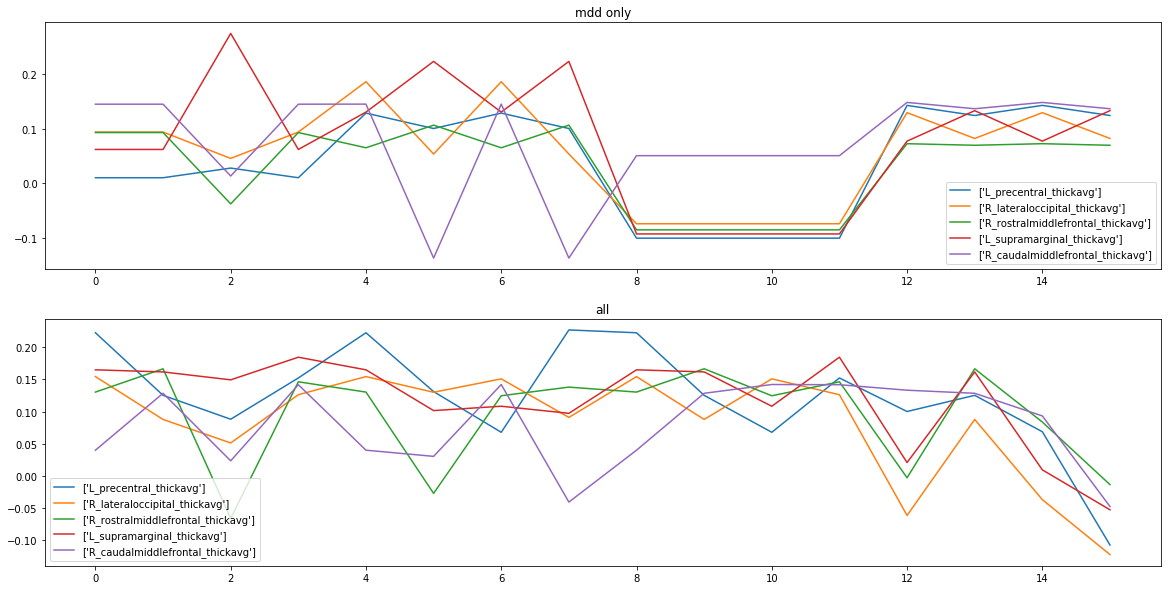

In [307]:
fig=plt.figure(figsize=[20,10])

plt.subplot(2,1,1); plt.plot(clusmdd[a[-5:],:].T);  
plt.title('mdd only'); plt.legend(Tclabels[a[-5:]])

plt.subplot(2,1,2); plt.plot(clusall[a[-5:],:].T);  
plt.title('all'); plt.legend(Tclabels[a[-5:]])

plt.show()

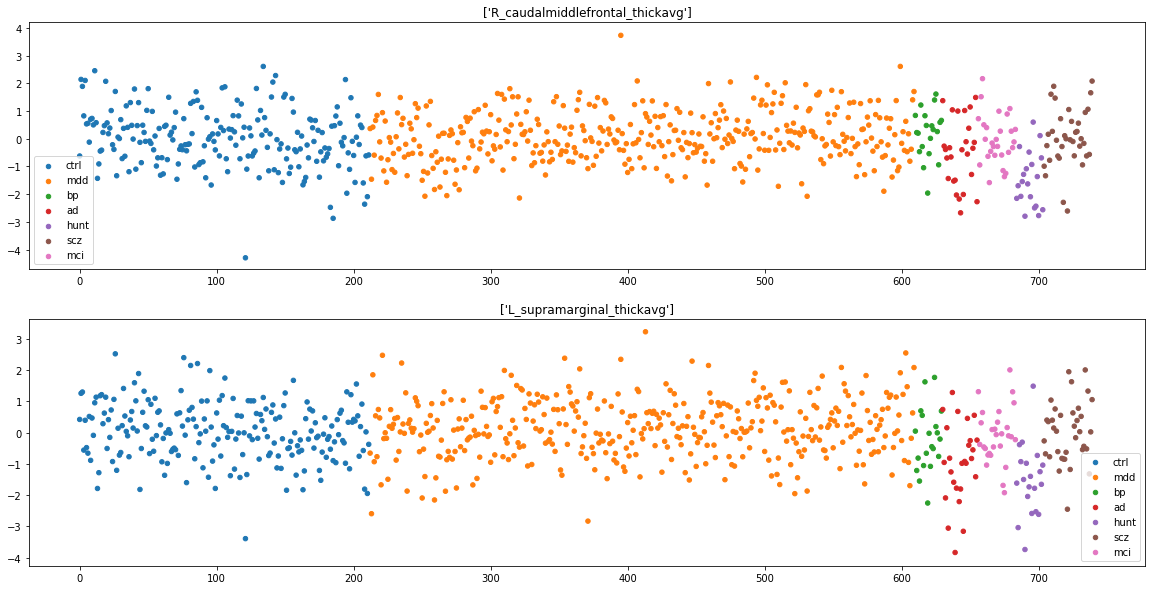

In [326]:
# let's have a closer look at R_caudalmiddlefrontal_thickavg
fig=plt.figure(figsize=[20,10])
ax = plt.subplot(2,1,1)
Xe=np.append(np.expand_dims(np.arange(740),axis=1),np.expand_dims(all_Tc[:,36],axis=1),axis=1)
colorscatter(Xe,sampleidx,np.ones(740)*4,ax)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.title(Tclabels[36])
ax = plt.subplot(2,1,2)
Xe=np.append(np.expand_dims(np.arange(740),axis=1),np.expand_dims(all_Tc[:,29],axis=1),axis=1)
colorscatter(Xe,sampleidx,np.ones(740)*4,ax)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.title(Tclabels[29])
plt.show()

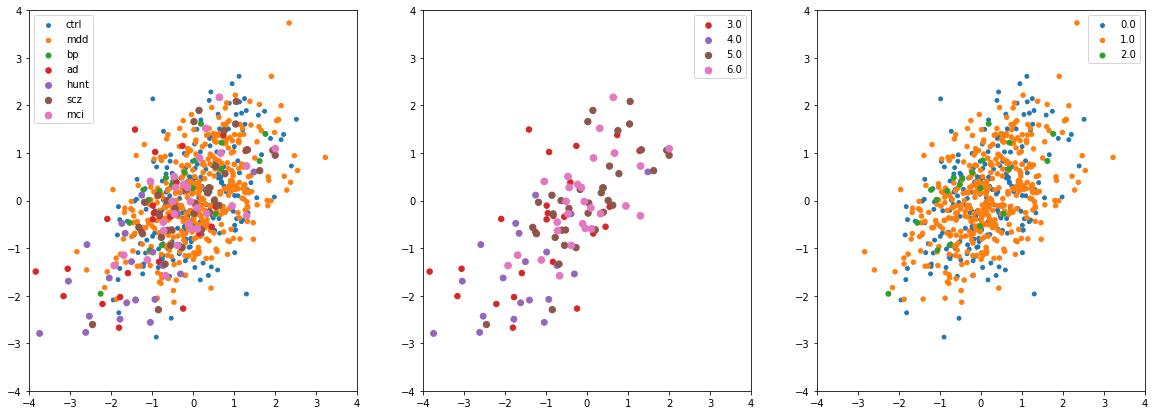

In [382]:
X=all_Tc[:,[29,36]]
sampleidx2=sampleidx-1
hunt_ad = np.concatenate([np.where(sampleidx==4)[0],np.where(sampleidx==5)[0]])
no_mdd_ctrl = np.where(sampleidx>3)[0]
just_mdd_ctrl = np.where(sampleidx<4)[0]

fig=plt.figure(figsize=[20,7])
ax = plt.subplot(1,3,1); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,sampleidx2,sampleidx+2,ax,0);plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
ax = plt.subplot(1,3,2); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[no_mdd_ctrl,:],sampleidx2[no_mdd_ctrl],sampleidx[no_mdd_ctrl]+2,ax,1)
ax = plt.subplot(1,3,3); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[just_mdd_ctrl,:],sampleidx2[just_mdd_ctrl],sampleidx[just_mdd_ctrl]+2,ax,1)
plt.show()

 correlation between ALL cluster 0 and MDD cluster 1: 0.5058710776857457


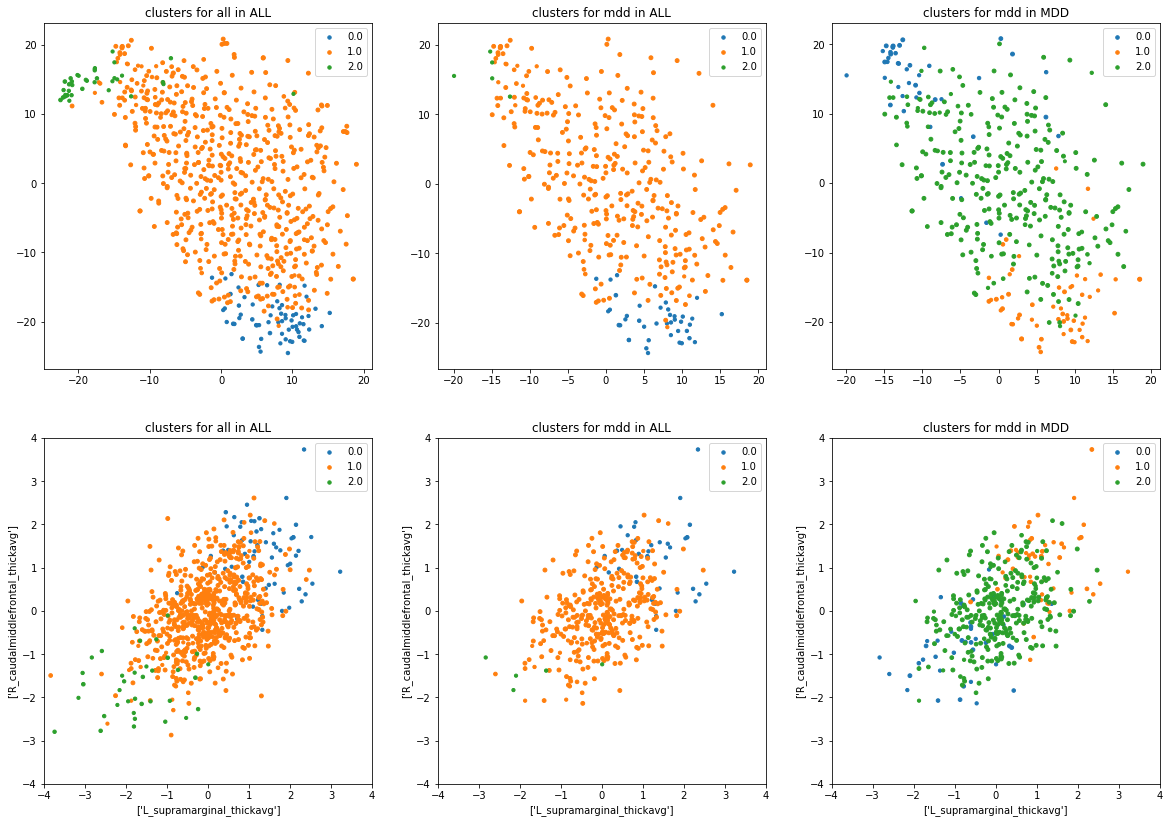

In [417]:
print(' correlation between ALL cluster 0 and MDD cluster 1:', mdd_all_corr[1,0,1,0]) #mdd_all_corr[clus_mdd,clus_all,mf_mdd,mf_all]
findmdd=np.where(dummy_mdd==1)[0]

X=all_tsne#all_Tc[:,[29,36]]

fig=plt.figure(figsize=[20,14])

ax = plt.subplot(2,3,1); plt.title('clusters for all in ALL'); 
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,3,2); plt.title('clusters for mdd in ALL'); 
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,3,3); plt.title('clusters for mdd in MDD'); 
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)

X=all_Tc[:,[29,36]]

ax = plt.subplot(2,3,4); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

ax = plt.subplot(2,3,5); plt.title('clusters for mdd in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

ax = plt.subplot(2,3,6); plt.title('clusters for mdd in MDD'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

plt.show()

[[ 17  41   1   0   1   4   2]
 [189 352  19  17   3  31  26]
 [  6   5   0   9  16   1   0]]


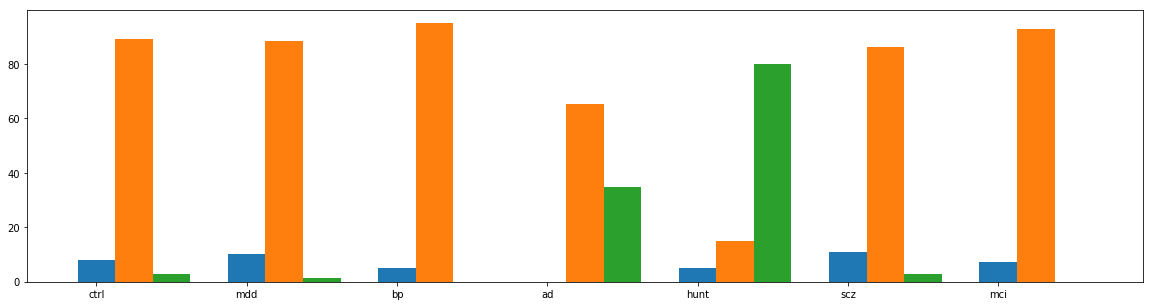

In [411]:
# what portion of controls falls into this cluster?
conmat = contingency_matrix(all_labelsmain2[:,0,2,0], sampleidx)
print(conmat) #['ctrl','mdd','bp','ad','hunt','scz','mci']
z=conmat*100/sum(conmat);

fig=plt.figure(figsize=[20,5])
ax=plt.subplot(1,1,1)
for m in range(3):
    ax.bar(np.arange(7) + 0.25*m, z[m], width = 0.25)
    plt.xticks(np.arange(7),['ctrl','mdd','bp','ad','hunt','scz','mci'])

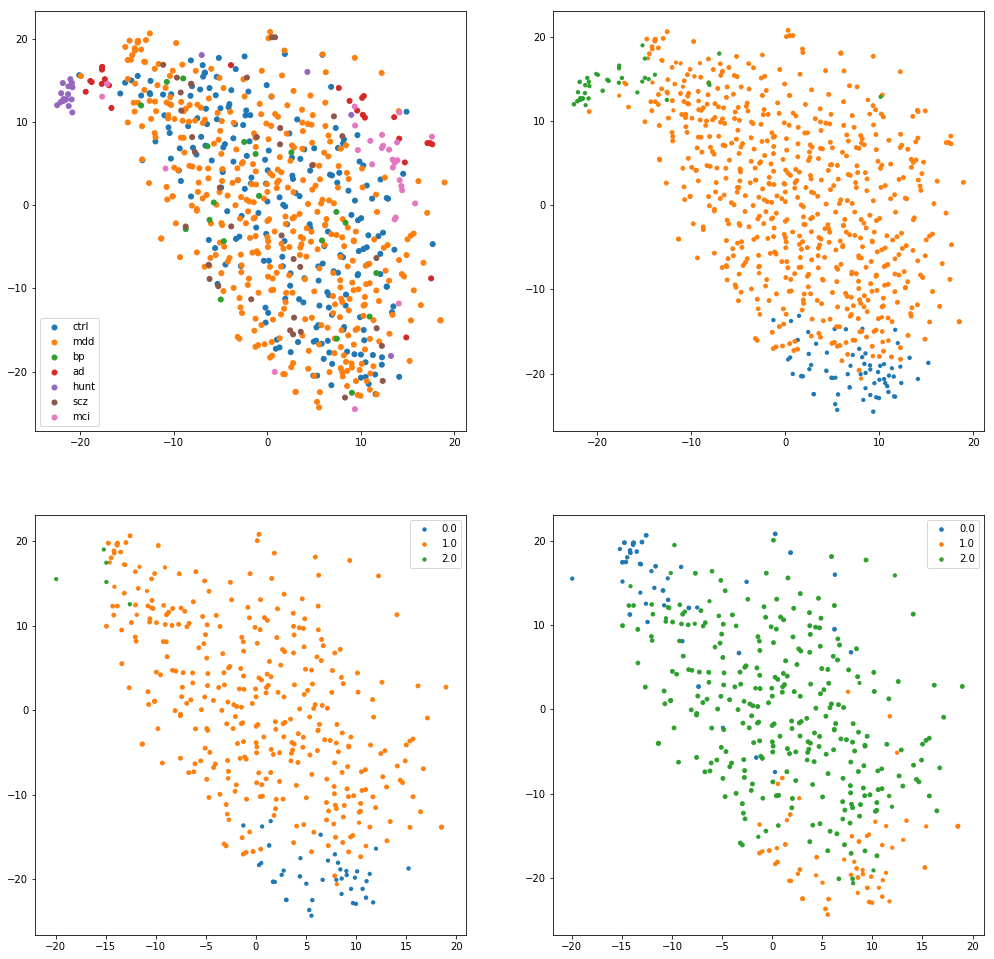

In [429]:
# just for bigger figures to stick into a powerpint

fig = plt.figure(figsize=[17,17])
ax = plt.subplot(2,2,1)
colorscatter(all_tsne,sampleidx-1,np.ones(740)*5, ax,0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
ax = plt.subplot(2,2,2); 
colorscatter(all_tsne,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,0)

ax = plt.subplot(2,2,3); 
colorscatter(all_tsne[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,2,4); 
colorscatter(all_tsne[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)

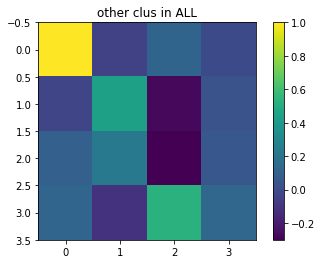

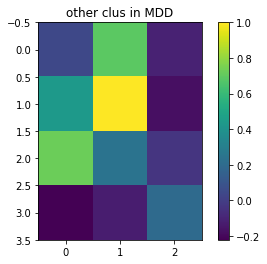

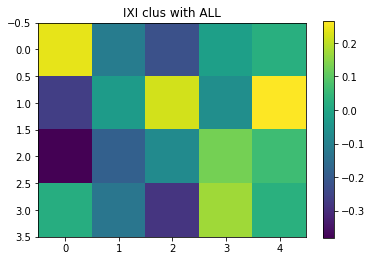

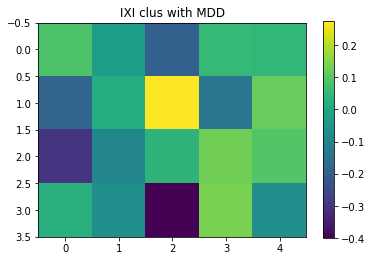

In [476]:
# use those two clusters as index to compare to the other mainfolds and to ixi
mddcrit=mdd_ctrl_betas[1:,1,1]
allcrit=all_betas[1:,0,0]

all_self_clus_corrs = np.full([4,4],np.nan)
mdd_self_clus_corrs = np.full([4,3],np.nan)

for mf in range(4):
    # all
    for clus in range(4):
        all_self_clus_corrs[mf,clus]=np.corrcoef(allcrit,all_betas[1:,clus,mf])[0,1]
    # mdd
    for clus in range(3):
        mdd_self_clus_corrs[mf,clus]=np.corrcoef(mddcrit,mdd_ctrl_betas[1:,clus,mf])[0,1]
# ixi with all
all_ixi_clus_corrs = all_ixi_corr[0,:,0,:].T 
# ixi with mdd
mdd_ixi_clus_corrs = mdd_ixi_corr[1,:,1,:].T

plt.imshow(all_self_clus_corrs); plt.colorbar(); plt.title('other clus in ALL'); plt.show()
plt.imshow(mdd_self_clus_corrs); plt.colorbar(); plt.title('other clus in MDD'); plt.show()
plt.imshow(all_ixi_clus_corrs); plt.colorbar(); plt.title('IXI clus with ALL'); plt.show()
plt.imshow(mdd_ixi_clus_corrs); plt.colorbar(); plt.title('IXI clus with MDD'); plt.show()

0.5058710776857457


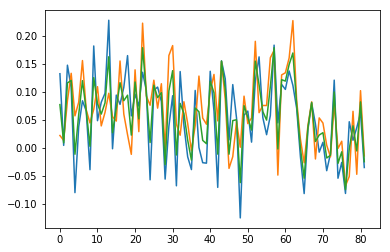

[['R_lateraloccipital_thickavg']
 ['L_middletemporal_thickavg']
 ['R_superiortemporal_thickavg']
 ['R_precuneus_thickavg']
 ['L_precentral_thickavg']]
[array([43, 13, 62, 57, 22])]
[0.15502119 0.1627847  0.16950459 0.17887509 0.17891234]


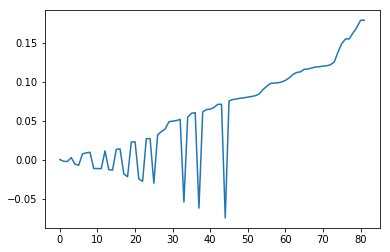

In [477]:
spit_out_vector_overlap(mddcrit,allcrit)

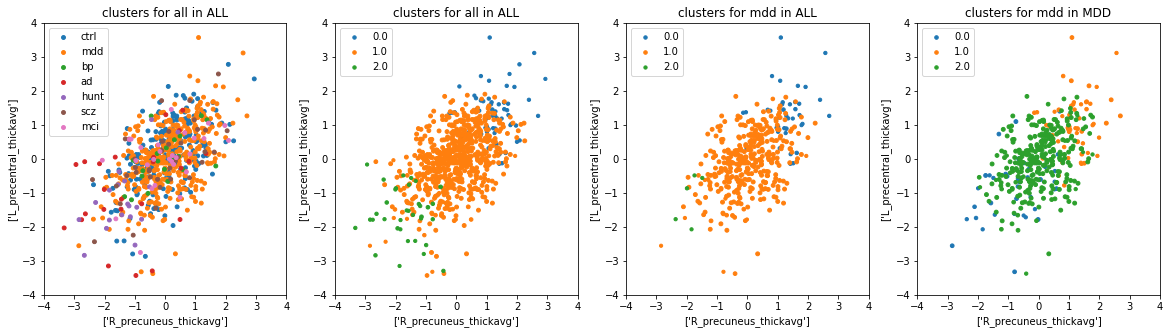

In [501]:
# top weights for the two clusters

X=all_Tc[:,[57,22]]

fig=plt.figure(figsize=[20,5])

ax = plt.subplot(1,4,1); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,sampleidx-1,np.ones(740)*3,ax,0); plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,2); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,3); plt.title('clusters for mdd in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,4); plt.title('clusters for mdd in MDD'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

plt.show()

##ixi same axes
#X=ixi_Tc[:,[57,22]]
#fig=plt.figure(figsize=[20,7])
#for mf in range(4):
#    labels = ixi_labelsmain2[:,0,3,mf]
#    probas = ixi_probamain2[:,0,3,mf]+1
#    ax = plt.subplot(1,4,mf+1)
#    colorscatter(X,labels,probas, ax,1)
#plt.show()


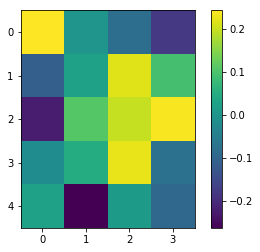

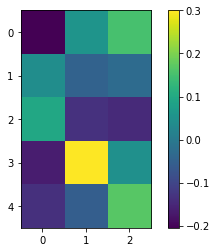

In [457]:
# the most similar solutions wiht ixi were at mf [0,0] for ALL and mf [3,3] for MDD
plt.imshow(all_ixi_corr[:,:,0,0].T ); plt.colorbar(); plt.show()
plt.imshow(mdd_ixi_corr[:,:,3,3].T ); plt.colorbar(); plt.show()

0.24218097778662373


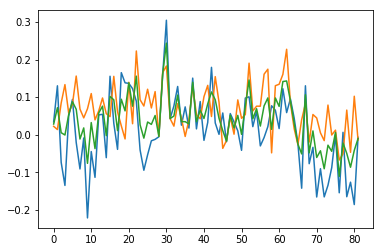

[['R_superiortemporal_thickavg']
 ['R_parstriangularis_thickavg']
 ['L_precentral_thickavg']
 ['L_supramarginal_thickavg']
 ['L_frontalpole_thickavg']]
[array([62, 52, 22, 29, 30])]
[0.14302312 0.145548   0.15575154 0.16086369 0.24356892]


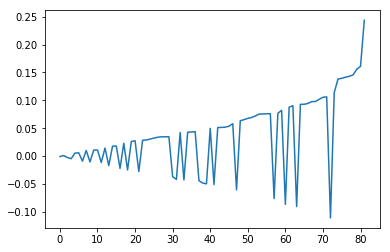

In [478]:
spit_out_vector_overlap(ixi_betas[1:,0,0],all_betas[1:,0,0])

0.23748727221868754


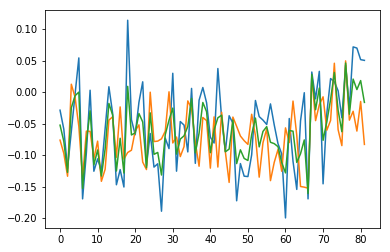

[['L_parsorbitalis_thickavg']
 ['L_superiorparietal_thickavg']
 ['L_lingual_thickavg']
 ['L_inferiorparietal_thickavg']
 ['R_transversetemporal_thickavg']]
[array([17, 27, 11,  6, 66])]
[-0.12849367 -0.13166318 -0.13335983 -0.1530834  -0.16103406]


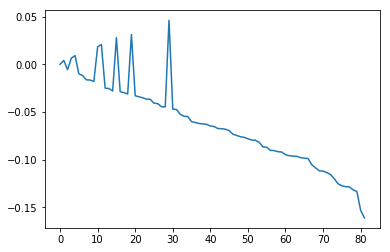

In [479]:
spit_out_vector_overlap(ixi_betas[1:,2,0],all_betas[1:,3,0])

0.21661234719234512


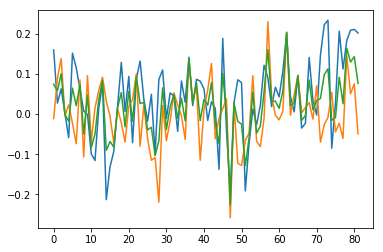

[['Rput']
 ['R_precuneus_thickavg']
 ['Rhippo']
 ['R_superiortemporal_thickavg']
 ['R_middletemporal_thickavg']]
[array([80, 57, 78, 62, 47])]
[ 0.14267261  0.15997467  0.16363958  0.20263132 -0.22638917]


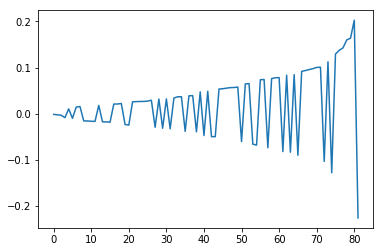

In [480]:
spit_out_vector_overlap(ixi_betas[1:,1,0],all_betas[1:,2,0])

0.22621841297077588


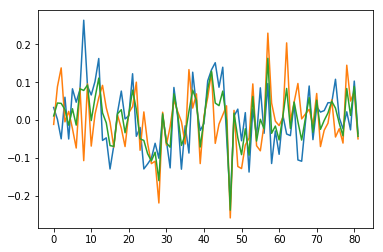

[['L_medialorbitofrontal_thickavg']
 ['R_isthmuscingulate_thickavg']
 ['L_superiortemporal_thickavg']
 ['R_precuneus_thickavg']
 ['R_middletemporal_thickavg']]
[array([12, 42, 28, 57, 47])]
[ 0.11077312  0.12932099 -0.15991611  0.16315006 -0.23789934]


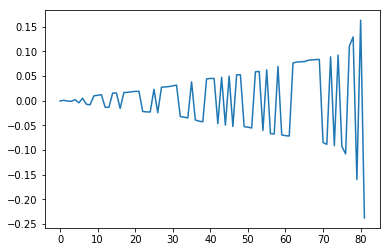

In [481]:
spit_out_vector_overlap(ixi_betas[1:,3,0],all_betas[1:,2,0])

0.30023389828642766


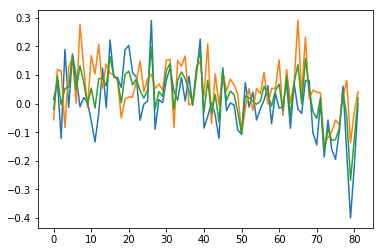

[['Lpal']
 ['L_fusiform_thickavg']
 ['R_fusiform_thickavg']
 ['L_superiorfrontal_thickavg']
 ['Rpal']]
[array([72,  5, 39, 26, 79])]
[-0.16514712  0.1666835   0.18658466  0.19631369 -0.2685176 ]


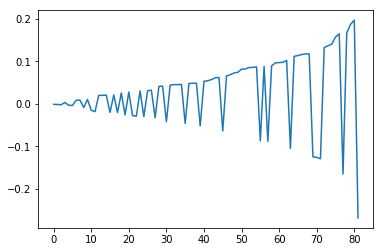

In [482]:
spit_out_vector_overlap(ixi_betas[1:,3,3],mdd_ctrl_betas[1:,1,3])

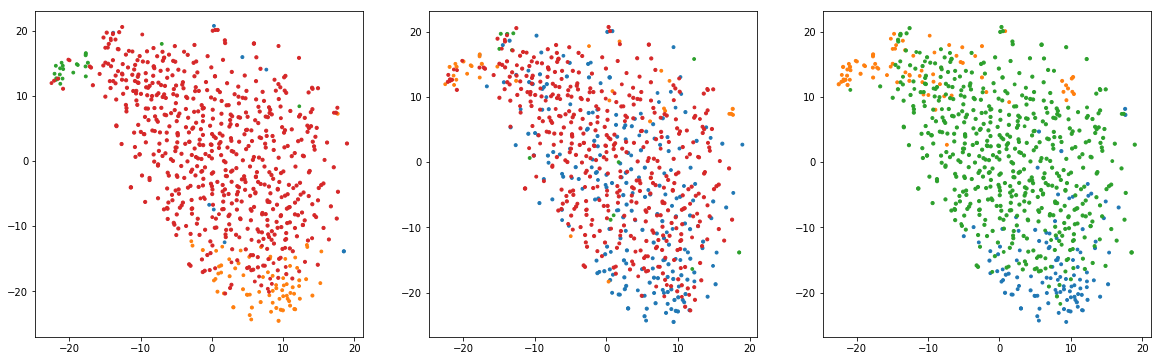

In [499]:
fig = plt.figure(figsize=[20,6])
for s in range(3):

    if s<2:
        labels = all_labelsmain2[:,s,2,1]
        probas = all_probamain2[:,s,2,1]+1
    else:
        labels = all_labelsmain2[:,s,1,1]
        probas = all_probamain2[:,s,1,1]+1
    
    ax = plt.subplot(1,3,s+1)
    colorscatter(all_tsne,labels,probas, ax,0)
    
plt.show()

In [498]:
np.unique(all_labelsmain2[:,0,4,0])

array([0., 1., 2., 3., 4., 5.])

In [508]:
import csv
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clusmdd.csv',mode='w') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(clusmdd)
file.close()
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clusall.csv',mode='w') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(clusall)
file.close()
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/Tclabels.csv',mode='w+',newline='') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(Tclabels)
file.close()

0.2742700445079815


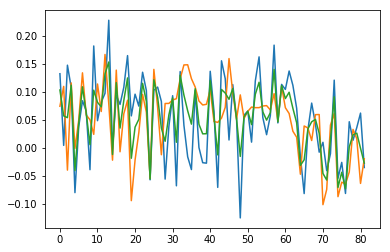

[['L_precentral_thickavg']
 ['L_paracentral_thickavg']
 ['R_pericalcarine_thickavg']
 ['R_inferiorparietal_thickavg']
 ['L_rostralmiddlefrontal_thickavg']
 ['L_parstriangularis_thickavg']
 ['L_transversetemporal_thickavg']
 ['L_medialorbitofrontal_thickavg']
 ['R_precuneus_thickavg']
 ['L_middletemporal_thickavg']]
[array([22, 15, 53, 40, 25, 18, 32, 12, 57, 13])]
[0.11544371 0.11667518 0.11730504 0.12046672 0.12170584 0.12504437
 0.12984777 0.13225905 0.14028133 0.15342398]


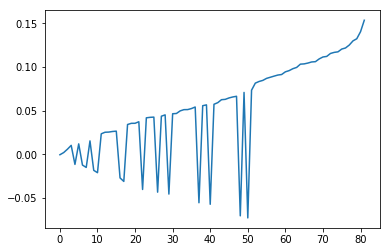

In [514]:
spit_out_vector_overlap(mdd_ctrl_betas[1:,1,1],ixi_betas[1:,2,1])

0.22139608548668407


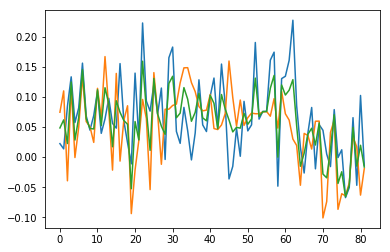

[['R_rostralmiddlefrontal_thickavg']
 ['L_supramarginal_thickavg']
 ['L_cuneus_thickavg']
 ['R_superiortemporal_thickavg']
 ['L_rostralmiddlefrontal_thickavg']
 ['R_parstriangularis_thickavg']
 ['L_frontalpole_thickavg']
 ['R_precuneus_thickavg']
 ['L_inferiorparietal_thickavg']
 ['L_precentral_thickavg']]
[array([59, 29,  3, 62, 25, 52, 30, 57,  6, 22])]
[0.11986522 0.12229773 0.12469516 0.1286052  0.13063025 0.13115831
 0.13422446 0.13565525 0.14505919 0.15919715]


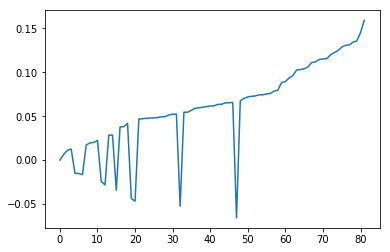

In [515]:
spit_out_vector_overlap(all_betas[1:,0,0],ixi_betas[1:,2,1])

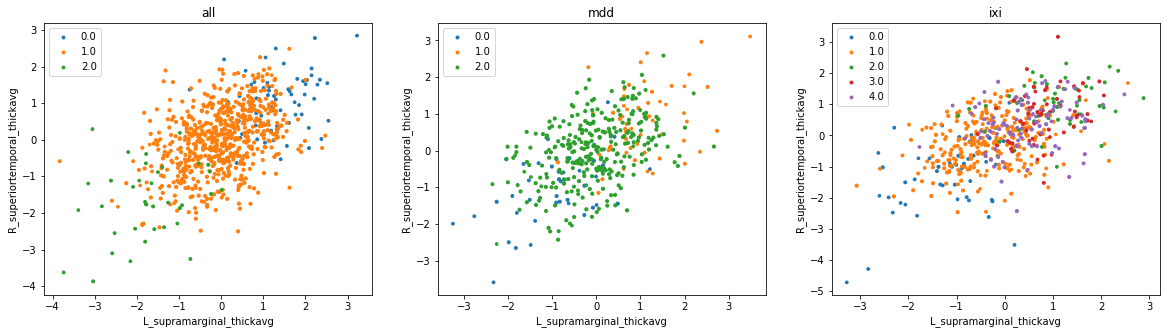

In [525]:
# plot all, mdd, and ixi on a l supramarginal, R suerior temporal space
all_labels_idx = all_labelsmain2[:,0,2,0] #f, set, k ,mainfold
mdd_labels_idx = mdd_ctrl_labelsmain2[:,0,1,1]
ixi_labels_idx = ixi_labelsmain2[:,0,3,1]
all_proba_idx = all_probamain2[:,0,2,0] #f, set, k ,mainfold
mdd_proba_idx = mdd_ctrl_probamain2[:,0,1,1]
ixi_proba_idx = ixi_probamain2[:,0,3,1]


fig=plt.figure(figsize=[20,5])
ax=plt.subplot(1,3,1);
colorscatter(all_Tc[:,[29,62]],all_labels_idx,all_proba_idx+1,ax,1); plt.title('all')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
ax=plt.subplot(1,3,2);
colorscatter(mdd_ctrl_Tc[:,[29,62]],mdd_labels_idx,mdd_proba_idx+1,ax,1); plt.title('mdd')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
ax=plt.subplot(1,3,3);
colorscatter(ixi_Tc[:,[29,62]],ixi_labels_idx,ixi_proba_idx+1,ax,1); plt.title('ixi')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
plt.show()

In [522]:
Tclabels[62]

array(['R_superiortemporal_thickavg'], dtype='<U35')